In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import nltk
import string
import seaborn
import re
import string as sns  # Tutorial about Python regular expressions: https://pymotw.com/2/re/
import pickle
import os
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics.classification import accuracy_score, log_loss
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter 
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm

In [21]:
svm_ar = pd.read_csv('Reviews.csv', nrows= 100000) #100k datapoints
svm_ar.shape

(100000, 10)

In [22]:
def partition (x):
    if x < 3:
        return 0
    return 1

actualScore = svm_ar['Score']
positivenegative = actualScore.map(partition)
svm_ar['Score'] = positivenegative


In [23]:
svm_ar.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [24]:
sorted_data = svm_ar.sort_values('ProductId', axis=0, ascending=True)
sorted_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
24749,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
24750,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
76852,76853,B00002N8SM,A392XPUTJDHSDJ,T. Chang,3,4,0,1264896000,Doesn't catch fruit flies,I don't know how this product performs with bi...
76871,76872,B00002N8SM,A2B7IZJ243KWFX,S. Pawar,0,0,0,1286236800,get something else,"bought this awhile ago, decided to review it n..."
76888,76889,B00002N8SM,A2Z0O52PKZPQ4H,river rat 222,1,3,0,1186876800,still waiting to catch a fly,With hundreds of common house flies all about ...


In [25]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final.shape

(88463, 10)

In [26]:
(final['Id'].size*1.0)/(svm_ar['Id'].size*1.0)*100

88.46300000000001

In [27]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [28]:
print(final.shape)
final['Score'].value_counts()

(88461, 10)


1    75313
0    13148
Name: Score, dtype: int64

<h2> Featurization </h2>

<h2> Bag Of Words </h2>

In [29]:
x = svm_ar['Text'].values
y= svm_ar['Score'].values

In [30]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) 

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english')
vectorizer.fit(X_train) 
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

(44890,) (44890,)
(22110,) (22110,)
(33000,) (33000,)
After vectorizations
(44890, 814414) (44890,)
(22110, 814414) (22110,)
(33000, 814414) (33000,)


# Applying SGDClassifier

In [35]:
from sklearn import linear_model
clf = SGDClassifier(class_weight = 'balanced', penalty='l1', loss ='hinge', random_state=42)
clf.fit(X_train_bow, y_train)
pred_1 = clf.predict(X_train_bow)
print(pred_1)

[0 1 1 ... 1 0 1]


# Best Hyper Parameter

In [38]:
from sklearn.model_selection import GridSearchCV
clf = SGDClassifier(class_weight = 'balanced')
param_grid = {'alpha':[10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]}
gsv = GridSearchCV(clf,param_grid, scoring='roc_auc')
gsv.fit(X_train_bow,y_train)  
print("Best HyperParameter: ",gsv.best_params_)

Best HyperParameter:  {'alpha': 0.001}


# Representation Of Results

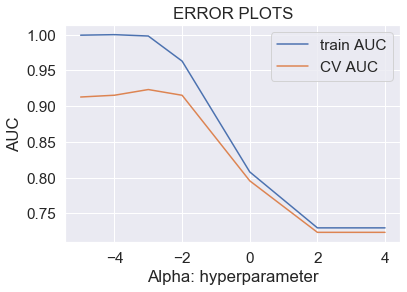

In [31]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
alpha =  [10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]
train_auc = []
cv_auc = []
for i in alpha:
    
    svc = SGDClassifier(class_weight = 'balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    svc.fit(X_train_bow, y_train)
    sig_clf = CalibratedClassifierCV(svc, method="sigmoid")
    sig_clf.fit(X_train_bow, y_train)
  
    y_train_pred =  sig_clf.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  sig_clf.predict_proba(X_cv_bow)[:,1]

    train_auc.append(roc_auc_score(y_train, sig_clf.predict_proba(X_train_bow)[:,1]))
    cv_auc.append(roc_auc_score(y_cv, sig_clf.predict_proba(X_cv_bow)[:,1]))

plt.plot(np.log10(alpha), train_auc, label="train AUC")
plt.plot(np.log10(alpha), cv_auc, label="CV AUC")
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show() 

<h2> Cofusion Matrix  </h2>

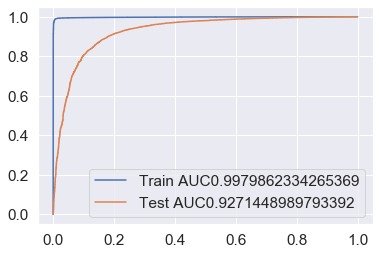

****************************** TRAIN DATA ******************************


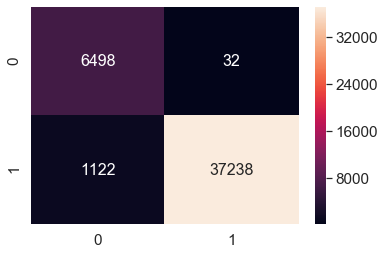

****************************** TEST DATA ******************************


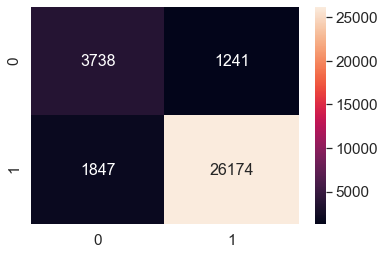

In [33]:
clf = SGDClassifier(class_weight = 'balanced', alpha=0.001, penalty='l2')
clf.fit(X_train_bow,y_train)
y_pred = clf.predict(X_train_bow)
y_pred_test = clf.predict(X_test_bow)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_bow, y_train)

y_test_pred_proba = sig_clf.predict_proba(X_test_bow)[:, 1]
y_train_pred_proba = sig_clf.predict_proba(X_train_bow)[:, 1]


train_fpr, train_tpr, thr_train = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thr_test = roc_curve(y_test, y_test_pred_proba)


plt.plot(train_fpr, train_tpr,label="Train AUC"+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,  label="Test AUC"+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.show()

print("*"*30, "TRAIN DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

print("*"*30, "TEST DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

# Top Feature Importance

In [32]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\t\tTop 10 Features Importance\t\t\t\t\t\t")
    print("________________________________________________________________________________________________")
   
    print("\tPositive Class\t\t\t\t\tNegative Class")
    print("________________________________________________________________________________________________")
    
     for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(vectorizer,clf)

				Top 10 Features Importance						
________________________________________________________________________________________________
	Positive Class					Negative Class
________________________________________________________________________________________________
	-0.6952	discontinued manufacturer				0.6353	excellent somewhat
	-0.6941	wrapper sticking				0.5906	delicious oats 
	-0.6484	texas hot      				0.5681	perfect works  
	-0.6250	disappointment broccoli				0.5639	best easiest   
	-0.6093	awkward amusing				0.5517	loves wax      
	-0.5583	weekend bit    				0.5386	work canned    
	-0.5294	hot wing       				0.5139	awesome value  
	-0.5182	standard velveeta				0.4997	great important
	-0.4576	tick           				0.4880	nice whisky    
	-0.4537	road husband   				0.4852	amazing idea   


# ========================================================

# TF_IDF

In [37]:
vectorizer_1 =  TfidfVectorizer(ngram_range=(1,2), stop_words='english')
vectorizer_1.fit(X_train) 

X_train_tfidf = vectorizer_1.transform(X_train)
X_cv_tfidf = vectorizer_1.transform(X_cv)
X_test_tfidf = vectorizer_1.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(44890, 814414) (44890,)
(22110, 814414) (22110,)
(33000, 814414) (33000,)


# Applying SGDClassifier

In [39]:
from sklearn import linear_model
clf = SGDClassifier(class_weight = 'balanced', penalty='l1', loss ='hinge', random_state=42)
clf.fit(X_train_tfidf, y_train)
clf.predict(X_train_tfidf)

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

# Best Hyper Parameter

In [40]:
clf = SGDClassifier(class_weight = 'balanced')
param_grid = {'alpha':[10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]}
gsv = GridSearchCV(clf,param_grid, scoring='roc_auc')
gsv.fit(X_train_tfidf,y_train)  
print("Best HyperParameter: ",gsv.best_params_)

Best HyperParameter:  {'alpha': 1e-05}


# Representation Of Results 

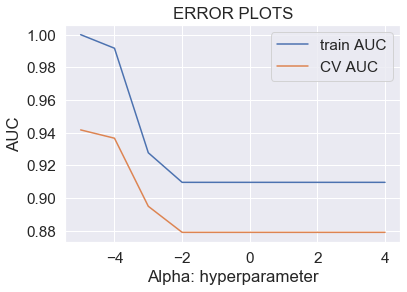

In [41]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
alpha =  [10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]
train_auc = []
cv_auc = []
for i in alpha:
    
    svc = SGDClassifier(class_weight = 'balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    svc.fit(X_train_tfidf, y_train)
    sig_clf = CalibratedClassifierCV(svc, method="sigmoid")
    sig_clf.fit(X_train_tfidf, y_train)
  
    y_train_pred =  sig_clf.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  sig_clf.predict_proba(X_cv_tfidf)[:,1]

    train_auc.append(roc_auc_score(y_train, sig_clf.predict_proba(X_train_tfidf)[:,1]))
    cv_auc.append(roc_auc_score(y_cv, sig_clf.predict_proba(X_cv_tfidf)[:,1]))

plt.plot(np.log10(alpha), train_auc, label="train AUC")
plt.plot(np.log10(alpha), cv_auc, label="CV AUC")
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show() 

# Confusion Matrix

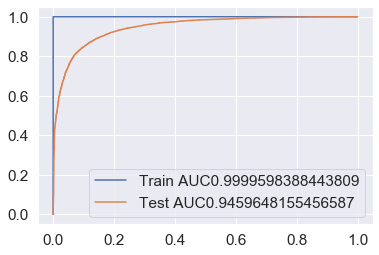

****************************** TRAIN DATA ******************************


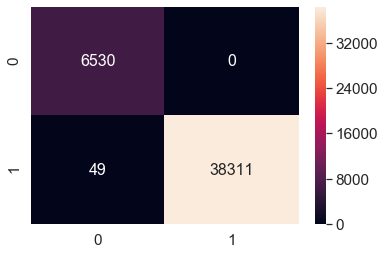

****************************** TEST DATA ******************************


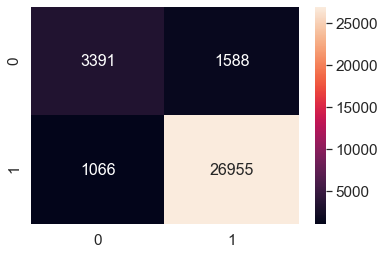

In [42]:
clf = SGDClassifier(class_weight = 'balanced', alpha=1e-05, penalty='l2')
clf.fit(X_train_tfidf,y_train)
y_pred = clf.predict(X_train_tfidf)
y_pred_test = clf.predict(X_test_tfidf)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_tfidf, y_train)

y_test_pred_proba = sig_clf.predict_proba(X_test_tfidf)[:, 1]
y_train_pred_proba = sig_clf.predict_proba(X_train_tfidf)[:, 1]


train_fpr, train_tpr, thr_train = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thr_test = roc_curve(y_test, y_test_pred_proba)

plt.plot(train_fpr, train_tpr,label="Train AUC"+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,  label="Test AUC"+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.show()

print("*"*30, "TRAIN DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

print("*"*30, "TEST DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

# Top Feature Importance

In [43]:
def show_most_informative_features(vectorizer_1, clf, n=10):
    feature_names = vectorizer_1.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\t\tTop 10 Features Importance\t\t\t\t\t\t")
    print("________________________________________________________________________________________________")
   
    print("\tPositive Class\t\t\t\t\tNegative Class")
    print("________________________________________________________________________________________________")
    
     
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(vectorizer_1,clf)

				Top 10 Features Importance						
________________________________________________________________________________________________
	Positive Class					Negative Class
________________________________________________________________________________________________
	-5.8225	worst          				6.1307	great          
	-4.7215	disappointed   				4.6767	delicious      
	-4.6695	terrible       				4.4569	best           
	-4.5738	disappointing  				4.0756	loves          
	-4.4794	awful          				4.0258	perfect        
	-4.4110	horrible       				4.0245	good           
	-4.1245	disappointment 				3.9509	love           
	-3.7284	return         				3.9155	excellent      
	-3.7043	weak           				3.6344	wonderful      
	-3.6686	poor           				3.3224	nice           


# =========================================================

# Word2Vec

In [44]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')


def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/|]',r' ',cleaned)
    return cleaned

print(stop)
print('******************************************')
print(sno.stem('tasty'))


{'having', 've', "should've", 'were', 'you', 'will', "wasn't", 'of', 'o', 'against', "wouldn't", 'an', 'yourselves', "you've", 'up', 'this', 'before', 'too', 'don', "aren't", 'what', 'in', 't', 'or', 'nor', 'did', 'on', 'aren', 'myself', "you're", 'all', 'doing', 'below', 'each', "haven't", 'with', "shan't", 'very', 're', 'he', "doesn't", 'which', 'because', 'most', 'own', 'has', 'they', 'she', 'shan', "didn't", 'her', 'being', 'some', 'we', "you'll", 'should', 'won', 'once', 'whom', 'couldn', "she's", 'be', 'how', 'now', 'ma', 'wasn', 'our', 'there', 'my', 'to', 'hers', 'not', "mightn't", 'here', 'then', 'ain', 'any', 'a', 'during', 'into', 'ours', 'can', 'himself', 'until', 'mightn', 'was', "isn't", 'the', 'same', 'such', 'these', "hadn't", 'when', 'mustn', 'haven', "it's", 'for', 'does', 'out', 'hadn', "that'll", 'after', 'do', 'yourself', 'that', 'and', 'under', 'just', 'down', 'them', 'needn', 'further', 'isn', 'had', 'off', 'weren', 'through', 'if', 'those', 'as', 'him', 'been', 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
i=0
str1=''
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=''
for sent in svm_ar['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (svm_ar['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                    if (svm_ar['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                    else:
                        continue
                else:
                    continue
    str1 = b" ".join(filtered_sentence)
   # print("***********************************************************************888")
    final_string.append(str1)
    i+=1

In [46]:
svm_ar['CleanedText']=final_string

In [47]:
import gensim
from gensim.models import word2vec
from gensim.models import keyedvectors
import pickle
#import gensim


i=0
list_of_sent=[]
for sent in svm_ar['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence) 

In [48]:
print(svm_ar['Text'].values[0])
print("***********************************************************************************")
print(list_of_sent[0])


I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
***********************************************************************************
['i', 'have', 'bought', 'several', 'of', 'the', 'vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', 'the', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', 'my', 'labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most']


In [49]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [50]:
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [51]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  25678
sample words  ['I', 'actually', 'thought', 'was', 'buying', 'the', 'Van', 'Houtte', 'vanilla', 'coffee', 'k-cups', 'that', 'usually', 'purchase', 'and', 'overlooked', 'description', 'of', 'It', 'certainly', 'is.', 'You', 'can', 'barely', 'taste', 'vanilla.', "It's", 'good', 'coffee,', 'but', 'if', "you're", 'looking', 'for', 'a', 'real', 'flavor,', 'go', 'with', 'are', 'in', 'darker', 'yellow', 'package.', 'never', 'liked', 'plain', 'green', 'tea.', 'would']


In [52]:
sent_vectors_train = [];
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|████████████████████████████████████████████████████████████████████████████| 44890/44890 [15:47<00:00, 47.38it/s]


(44890, 50)
[ 0.5982457  -0.59018794 -0.40568899 -0.05742073  0.90993628 -0.36069727
 -1.04450116 -0.38546672  0.84558916 -0.19327741  0.06307131  0.23428714
 -0.06265396  0.13305071  0.59908884  0.18111331 -0.5497627   0.37170972
 -0.29217701  0.74395914  0.6158984   1.15626576  1.04560044  0.21630455
 -0.49213903  0.16174902 -0.19315999 -0.4860116  -0.71910093 -0.68450438
  0.45311897  0.03225166 -0.67295327 -0.11534135  0.36816621  0.15794068
 -0.59000896  0.54460044 -0.16775861 -0.01333614  0.46682021 -0.02142094
  0.06341131 -0.3156919  -0.16058922 -0.20164235  0.17152774 -0.5492596
  0.83183226  0.06073188]


In [53]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [54]:

list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
sent_vectors_cv = []; 
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|████████████████████████████████████████████████████████████████████████████| 22110/22110 [07:09<00:00, 51.50it/s]


(22110, 50)
[ 7.20925571e-01 -5.52233616e-01 -6.46712919e-04  1.19106477e-01
  1.50591944e+00  2.70235275e-01 -6.71684579e-01 -1.37554162e-01
  2.10398943e-01  7.96133496e-02  2.51232328e-01 -3.57243455e-01
 -4.98340594e-01  3.68008121e-01  5.76847749e-01  3.80130645e-01
  1.45188534e-01 -2.07279611e-01 -6.01421107e-01  1.08385355e+00
 -3.38500082e-02  1.11347079e+00  2.68969498e-01  4.08537091e-01
 -3.02080237e-01  6.10877752e-01 -3.65009337e-01 -1.22984945e+00
 -5.81373490e-01 -6.95463671e-01  7.15934549e-01 -1.81381557e-01
  1.04984026e-01 -8.84888324e-01  5.91959404e-01  2.35118519e-01
  8.98523031e-02 -1.09942075e-02 -4.61904198e-01  6.88097651e-02
 -4.24764184e-02  1.81791094e-01  5.29792100e-02 -1.10928111e-01
  1.42056428e-01 -8.56026736e-02  1.00964768e-01  4.21075518e-01
  8.40814545e-01  1.08260397e-01]


In [55]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [56]:

sent_vectors_test = []; 
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|████████████████████████████████████████████████████████████████████████████| 33000/33000 [10:56<00:00, 50.24it/s]


(33000, 50)
[ 0.01894849 -0.27182396  0.20163799 -0.29627962  0.42128058  0.06719538
 -1.06592071  0.61798792 -0.00901188  0.45248877 -0.00785376  0.3388816
 -0.66022002  0.3726968   0.42431092 -0.39884913 -0.12558587  0.11001196
  0.04525854  0.99580584 -0.26350583  0.87677342  0.32381497 -0.15316183
  0.32696914 -0.76355993 -0.04860803  0.03598191 -0.17885694 -0.1975987
 -0.35764415  0.34036361 -0.84089844  0.5723898   1.05935296  0.99983011
 -0.13042034  0.61283309 -0.00828065 -0.02306322  0.30593673 -0.47328527
  0.42234896 -0.66746221 -0.04378773 -1.09576763  0.6382791   0.07718357
  0.63378569 -0.34168722]


# Applying SGDClassifier

In [57]:
from sklearn import linear_model
clf = SGDClassifier(class_weight = 'balanced', penalty='l1', loss ='hinge', random_state=42)
clf.fit(sent_vectors_train, y_train)
clf.predict(sent_vectors_train)

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

# Best Hyper Parameter

In [59]:
clf = SGDClassifier(class_weight = 'balanced')
param_grid = {'alpha':[10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]}
gsv = GridSearchCV(clf,param_grid, scoring='roc_auc')
gsv.fit(sent_vectors_train,y_train)  
print("Best HyperParameter: ",gsv.best_params_)

Best HyperParameter:  {'alpha': 0.001}


# Representation Of Results 

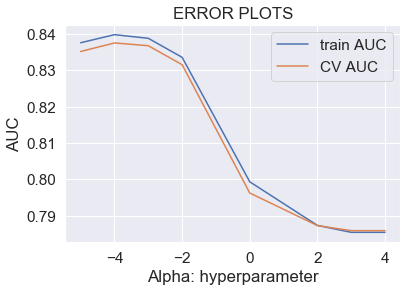

In [60]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
alpha =  [10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]
train_auc = []
cv_auc = []
for i in alpha:
    
    svc = SGDClassifier(class_weight = 'balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    svc.fit(sent_vectors_train, y_train)
    sig_clf = CalibratedClassifierCV(svc, method="sigmoid")
    sig_clf.fit(sent_vectors_train, y_train)
  
    y_train_pred =  sig_clf.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  sig_clf.predict_proba(sent_vectors_cv)[:,1]

    train_auc.append(roc_auc_score(y_train, sig_clf.predict_proba(sent_vectors_train)[:,1]))
    cv_auc.append(roc_auc_score(y_cv, sig_clf.predict_proba(sent_vectors_cv)[:,1]))

plt.plot(np.log10(alpha), train_auc, label="train AUC")
plt.plot(np.log10(alpha), cv_auc, label="CV AUC")
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show() 

# Confusion Matrix

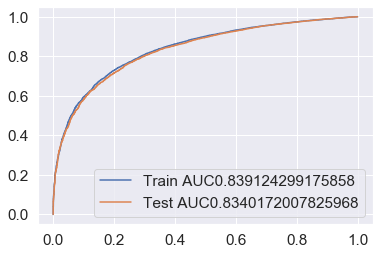

****************************** TRAIN DATA ******************************


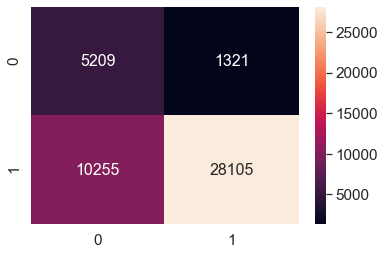

****************************** TEST DATA ******************************


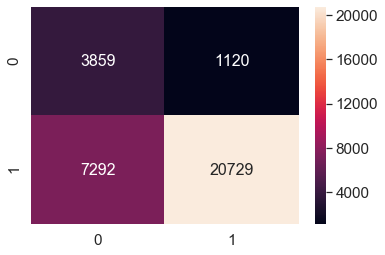

In [61]:
clf = SGDClassifier(class_weight = 'balanced', alpha=0.001, penalty='l2')
clf.fit(sent_vectors_train,y_train)
y_pred = clf.predict(sent_vectors_train)
y_pred_test = clf.predict(sent_vectors_test)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(sent_vectors_train, y_train)

y_test_pred_proba = sig_clf.predict_proba(sent_vectors_test)[:, 1]
y_train_pred_proba = sig_clf.predict_proba(sent_vectors_train)[:, 1]


train_fpr, train_tpr, thr_train = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thr_test = roc_curve(y_test, y_test_pred_proba)

plt.plot(train_fpr, train_tpr,label="Train AUC"+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,  label="Test AUC"+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.show()

print("*"*30, "TRAIN DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

print("*"*30, "TEST DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

# ====================================================

# AvgWord2Vec

## For Train Data

In [62]:
from tqdm import tqdm 
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(svm_ar['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()
tfidf_sent_vectors_train = [];  
row=0;
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
     
tfidf_sent_vectors_train = np.array(sent_vectors_train)
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

100%|██████████████████████████████████████████████████████████████████████████| 44890/44890 [1:54:35<00:00,  9.11it/s]


(44890, 50)
[ 0.5982457  -0.59018794 -0.40568899 -0.05742073  0.90993628 -0.36069727
 -1.04450116 -0.38546672  0.84558916 -0.19327741  0.06307131  0.23428714
 -0.06265396  0.13305071  0.59908884  0.18111331 -0.5497627   0.37170972
 -0.29217701  0.74395914  0.6158984   1.15626576  1.04560044  0.21630455
 -0.49213903  0.16174902 -0.19315999 -0.4860116  -0.71910093 -0.68450438
  0.45311897  0.03225166 -0.67295327 -0.11534135  0.36816621  0.15794068
 -0.59000896  0.54460044 -0.16775861 -0.01333614  0.46682021 -0.02142094
  0.06341131 -0.3156919  -0.16058922 -0.20164235  0.17152774 -0.5492596
  0.83183226  0.06073188]


## For Cross-Validation-Data

In [63]:
from tqdm import tqdm 
model = TfidfVectorizer()
tfidf_sent_vectors_cv = [];
row=0;
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
tfidf_sent_vectors_cv = np.array(sent_vectors_cv)
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])   

100%|████████████████████████████████████████████████████████████████████████████| 22110/22110 [44:54<00:00, 11.75it/s]


(22110, 50)
[ 7.20925571e-01 -5.52233616e-01 -6.46712919e-04  1.19106477e-01
  1.50591944e+00  2.70235275e-01 -6.71684579e-01 -1.37554162e-01
  2.10398943e-01  7.96133496e-02  2.51232328e-01 -3.57243455e-01
 -4.98340594e-01  3.68008121e-01  5.76847749e-01  3.80130645e-01
  1.45188534e-01 -2.07279611e-01 -6.01421107e-01  1.08385355e+00
 -3.38500082e-02  1.11347079e+00  2.68969498e-01  4.08537091e-01
 -3.02080237e-01  6.10877752e-01 -3.65009337e-01 -1.22984945e+00
 -5.81373490e-01 -6.95463671e-01  7.15934549e-01 -1.81381557e-01
  1.04984026e-01 -8.84888324e-01  5.91959404e-01  2.35118519e-01
  8.98523031e-02 -1.09942075e-02 -4.61904198e-01  6.88097651e-02
 -4.24764184e-02  1.81791094e-01  5.29792100e-02 -1.10928111e-01
  1.42056428e-01 -8.56026736e-02  1.00964768e-01  4.21075518e-01
  8.40814545e-01  1.08260397e-01]


## For Test Data

In [64]:
from tqdm import tqdm 
model = TfidfVectorizer()

tfidf_sent_vectors_test = [];
row=0;
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))  
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

100%|██████████████████████████████████████████████████████████████████████████| 33000/33000 [1:06:00<00:00,  8.33it/s]


(33000, 50)
[ 7.47008769e-02 -1.20898674e+00 -8.15174870e-01 -6.81434791e-01
  2.25858017e+00  6.87869185e-01 -8.11129085e-01  5.40451896e-01
  2.96532837e-01  6.33376411e-02  6.54011276e-02  3.35804248e-01
  1.32918789e-03 -2.10007937e-01  5.83815113e-01 -9.09108961e-01
 -1.04936113e+00 -4.28286339e-01  4.01341785e-01  1.79498775e+00
 -6.87232052e-01  1.89041312e+00 -5.21510344e-01 -3.81825451e-01
  8.99320716e-01 -8.09731510e-01  8.03747987e-02  6.75405302e-01
 -9.67695394e-02 -1.02710393e+00  7.95818028e-01  6.47469203e-01
  5.78269489e-01  1.31803820e+00  1.17612917e+00  3.26700450e-01
 -8.67318006e-01  1.00678259e+00 -7.45883998e-02  1.08194344e+00
  1.67051024e-01 -5.45768739e-01  1.00619092e+00  1.08933855e+00
 -2.68054202e-01 -1.68198991e+00  1.95150438e-01  4.93280739e-02
  1.20154034e+00  7.28286590e-01]


# Applying SGDClassifier

In [65]:
from sklearn import linear_model
clf = SGDClassifier(class_weight = 'balanced', penalty='l1', loss ='hinge', random_state=42)
clf.fit(tfidf_sent_vectors_train, y_train)
clf.predict(tfidf_sent_vectors_train)

array([0, 1, 1, ..., 1, 1, 1], dtype=int64)

# Best Hyper Parameter

In [66]:
clf = SGDClassifier(class_weight = 'balanced')
param_grid = {'alpha':[10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]}
gsv = GridSearchCV(clf,param_grid, scoring='roc_auc')
gsv.fit(tfidf_sent_vectors_train,y_train)  
print("Best HyperParameter: ",gsv.best_params_)

Best HyperParameter:  {'alpha': 0.001}


# For Representation Of Results 

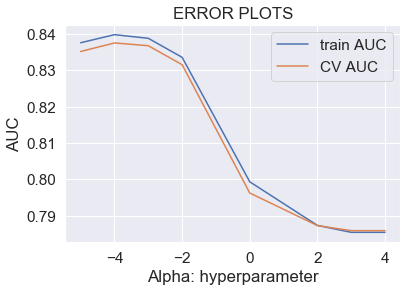

In [67]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
alpha =  [10**-5, 10**-4, 10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]
train_auc = []
cv_auc = []
for i in alpha:
    
    svc = SGDClassifier(class_weight = 'balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    svc.fit(tfidf_sent_vectors_train, y_train)
    sig_clf = CalibratedClassifierCV(svc, method="sigmoid")
    sig_clf.fit(tfidf_sent_vectors_train, y_train)
  
    y_train_pred =  sig_clf.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  sig_clf.predict_proba(tfidf_sent_vectors_cv)[:,1]

    train_auc.append(roc_auc_score(y_train, sig_clf.predict_proba(tfidf_sent_vectors_train)[:,1]))
    cv_auc.append(roc_auc_score(y_cv, sig_clf.predict_proba(tfidf_sent_vectors_cv)[:,1]))

plt.plot(np.log10(alpha), train_auc, label="train AUC")
plt.plot(np.log10(alpha), cv_auc, label="CV AUC")
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show() 

# Confusion Matrix

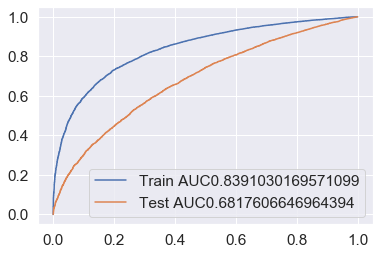

****************************** TRAIN DATA ******************************


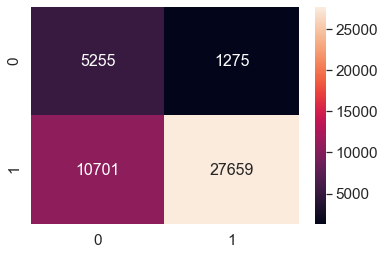

****************************** TEST DATA ******************************


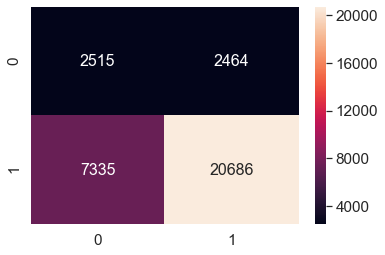

In [68]:
clf = SGDClassifier(class_weight = 'balanced', alpha=0.001, penalty='l2')
clf.fit(tfidf_sent_vectors_train,y_train)
y_pred = clf.predict(tfidf_sent_vectors_train)
y_pred_test = clf.predict(tfidf_sent_vectors_test)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_sent_vectors_train, y_train)

y_test_pred_proba = sig_clf.predict_proba(tfidf_sent_vectors_test)[:, 1]
y_train_pred_proba = sig_clf.predict_proba(tfidf_sent_vectors_train)[:, 1]


train_fpr, train_tpr, thr_train = roc_curve(y_train, y_train_pred_proba)
test_fpr, test_tpr, thr_test = roc_curve(y_test, y_test_pred_proba)

plt.plot(train_fpr, train_tpr,label="Train AUC"+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr,  label="Test AUC"+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.show()

print("*"*30, "TRAIN DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

print("*"*30, "TEST DATA", "*"*30)
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.show()

# ===========================================================

# Conclusion Table

In [1]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Set", "Vectorizer", "Model 1", "Hyper Parameter", "TRAIN_AUC", "TEST_AUC"]
x.add_row(["Set:-1", "BOW", "SVM_Linear", 0.01, 0.99, 0.92])
x.add_row(["Set:-2", "TFIDF", "SVM_Linear", 1e-05, 0.99, 0.94])
x.add_row(["Set:-3", "W2V", "SVM_Linear", 0.001, 0.83, 0.83])
x.add_row(["Set:-4", "AvgW2V", "SVM_linear", 0.001, 0.83, 0.68])
x.add_row(["Set:-5", "BOW", "SVM_Kernel", 1, 0.90, 0.85])
x.add_row(["Set:-6", "TFIDF", "SVM_kernel", 100, 0.91, 0.87])
x.add_row(["Set:-7", "W2V", "SVM_kernel", 100, 0.82, 0.79])
x.add_row(["Set:-8", "AvgW2V", "SVM_kernel", 100, 0.82, 0.79])
print(x)

+--------+------------+------------+-----------------+-----------+----------+
|  Set   | Vectorizer |  Model 1   | Hyper Parameter | TRAIN_AUC | TEST_AUC |
+--------+------------+------------+-----------------+-----------+----------+
| Set:-1 |    BOW     | SVM_Linear |       0.01      |    0.99   |   0.92   |
| Set:-2 |   TFIDF    | SVM_Linear |      1e-05      |    0.99   |   0.94   |
| Set:-3 |    W2V     | SVM_Linear |      0.001      |    0.83   |   0.83   |
| Set:-4 |   AvgW2V   | SVM_linear |      0.001      |    0.83   |   0.68   |
| Set:-5 |    BOW     | SVM_Kernel |        1        |    0.9    |   0.85   |
| Set:-6 |   TFIDF    | SVM_kernel |       100       |    0.91   |   0.87   |
| Set:-7 |    W2V     | SVM_kernel |       100       |    0.82   |   0.79   |
| Set:-8 |   AvgW2V   | SVM_kernel |       100       |    0.82   |   0.79   |
+--------+------------+------------+-----------------+-----------+----------+


# Conclusion

1. First i loaded an amazon fine food reviews dataset and took 100k datapoints for featurization
2. Then Did featurization BOW , TF_IDF, W2Vec , and AvgW2Vec featurization and applied SVM.Linear with SGD classification.
3. Then find top feature Importance in amazon fine food reviews which featrures is importsnce in that dataset.
4. Then did feature Engineering using ungran and bi-gram in amazon fine food reviews
5. Then  find Hyper parameter best alpha with 10**-4 to 10**4 range using gridsearchcrossvalidation .
6. Then plot hyper parameter plot for train data, cross-validation data , test data .
7. Then find Confusion-Matrix where predicated and actual values calculated with alpha in it.

# ============================================================